# Import libraries

In [635]:
import numpy as np
import scipy as sp

import torch

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from dataclasses import dataclass
from abc import ABC, abstractmethod

import time

# Set constants

In [636]:
# paths
FONT_PATH     = '../../extra/Cinzel-VariableFont_wght.ttf'
IMAGES_PATH   = 'images'
# colors
RED        = '#6F1D1B'
RICH_BLACK = '#011627'
# font size
SIZE_TICKS = 12
SIZE_AXIS_NAMES = 22
SIZE_TITLE = 16
SIZE_LEGEND = 12

SAVE = False

# Load fonts

In [637]:
cinzel_font = fm.FontProperties(fname=FONT_PATH)
fm.fontManager.addfont(FONT_PATH)

# Define styles

In [638]:
# classical line plot style 
classic_style = {
    "font.family": cinzel_font.get_name(), # apply Cinzel font
    "font.size": SIZE_TITLE
}

In [639]:
plt.rcdefaults() # reset to defauls

# Helper functions

In [640]:
# helper function to decorate plots
def decorate_regular_plot(ax, xname: str, 
                              yname: str, 
                              loc=None) -> None:
    SIZE_TICKS = 12

    # show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # x axis name
    ax.set_xlabel(xname, fontsize=SIZE_AXIS_NAMES, labelpad=10)

    # y axis name
    ax.set_ylabel(yname, fontsize=SIZE_AXIS_NAMES, labelpad=10)

    # adjust the font size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=SIZE_TICKS)

    if loc:
        plt.legend(fontsize=SIZE_LEGEND, loc=loc)

    # adjust layout
    plt.tight_layout()

# Utils

In [641]:
# Define a helper class for points 
# of type (x, y)
@dataclass
class Point:
    x: float
    y: float

    def __str__(self):
        return f'(x={self.x}; y={self.y})'
    
    def __lt__(self, other):
        return self.y <= other.y
    
    def __format__(self, format_spec):
        format_x = format(self.x, format_spec)
        format_y = format(self.y, format_spec)
        return  f'(x={format_x}; y={format_y})'


In [642]:
# Define an abstract class
class Optimization(ABC):
    def __init__(self, func) -> None:
        self.func = func   

    # Метод равномерного поиска
    @abstractmethod
    def uniform_search(self, a: float, 
                             b: float,
                             n: int,
                             add_to_comparison: bool,
                             *args):
        pass

    # Метод ломаных
    @abstractmethod
    def broken_lines(self):
        pass

    # Метод секущих
    @abstractmethod
    def secant(self):
        pass

    # Метод Ньютона
    @abstractmethod
    def newton(self):
        pass

In [643]:
class Comparison:
    @dataclass
    class Method:
        name: str
        implementation_type: str
        result: Point
        execution_time: float
        details: str = ''

    def __init__(self) -> None:
        self.data = []

    def add_data(self, method: Method) -> None:
        self.data.append(method)
    
    def get_data(self) -> list[Method]:
        return self.data

# Initial data

In [644]:
# define a function
def func(x, a, b, c, d) -> float:
    return a * x**3 + b * x**2 + c * x + d

# randomly choose coefficients
A, B, C, D = 89, 45, -44, 68

INTERVAL = (-0.5, 1)

# create a Comparison object
cmpr = Comparison()

# Initial analysis

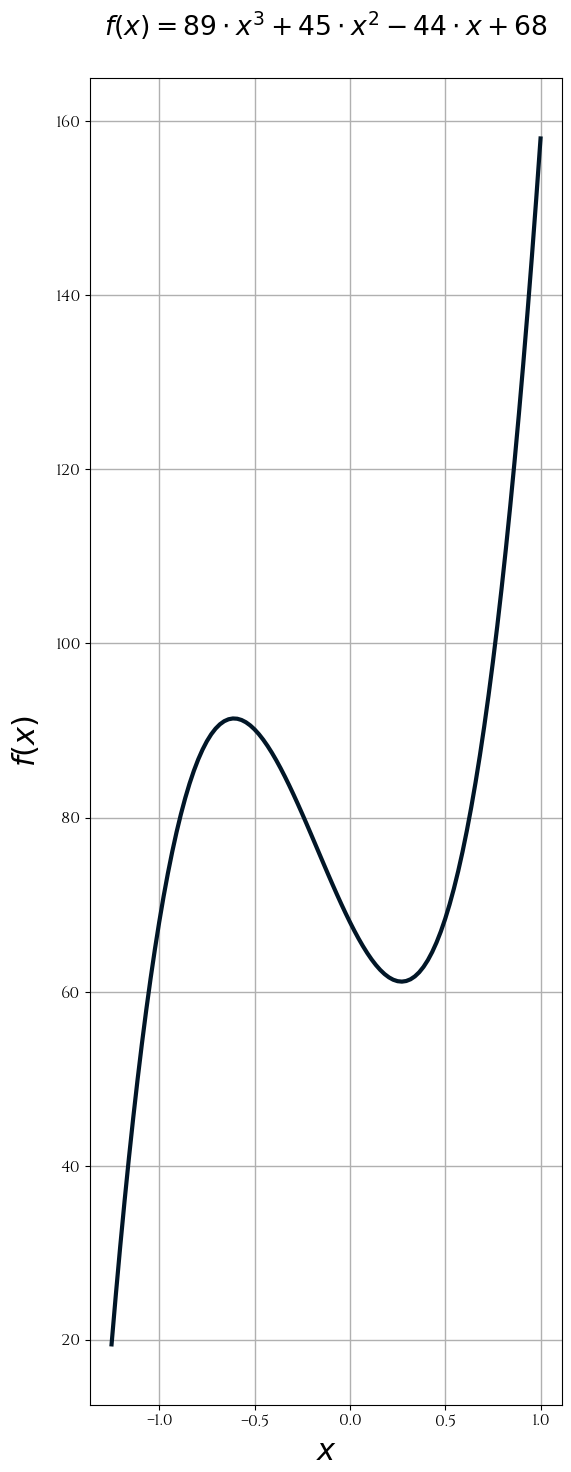

In [645]:
myfunc = lambda x : func(x, A, B, C, D)

# create plot 
with plt.rc_context(classic_style): # use context for styles not to interfere
    fig, ax = plt.subplots(figsize=(6, 15))

    x_values = np.linspace(-1-0.25, 0.75+0.25, 100)
    y_values = myfunc(x_values)

    ax.plot(x_values, y_values, color=RICH_BLACK, linewidth=3)

    ax.set_title(f'$f(x) = {A} \\cdot x^3 {'+' if B > 0 else ''} {B} \\cdot x^2 {'+' if C > 0 else ''} {C} \\cdot x {'+' if D > 0 else ''} {D}$',
                 pad=30)
    decorate_regular_plot(ax, '$x$', '$f(x)$')

    ax.grid(linewidth=1)

    if SAVE:
        plt.savefig(f'{IMAGES_PATH}/initial_f_plot.png', 
                    dpi=300, transparent=True)

    plt.show()

<h2> <center> Analytical implementation </center> </h2>

In [646]:
# class for analytical implementations
class OptimizationAnalytical(Optimization):
    # Метод равномерного поиска
    def uniform_search(self, a: float, 
                             b: float,
                             n: int = 1000,
                             add_to_comparison: bool = True,
                             showplot: bool = False):
        
        # start timer
        start_time = time.perf_counter()

        points, minpoint = [], None
        for i in range(1, n + 1):
            x = a + i * (b - a)/(n + 1)
            y = self.func(x)
            point = Point(x, y)
            points.append(point)

            if minpoint is None:
                minpoint = point
            else:
                minpoint = min(minpoint, point)

        # end timer
        result_time = time.perf_counter() - start_time

        # add data to Comparison class
        if add_to_comparison:
            method = Comparison.Method('uniform_search', 'analytical', 
                                        minpoint, result_time)
            cmpr.add_data(method)

        if showplot:
            # create plot 
            with plt.rc_context(classic_style): # use context for styles not to interfere
                _, ax = plt.subplots(figsize=(6, 15))

                x_values = np.linspace(-1-0.25, 0.75+0.25, 100)
                y_values = myfunc(x_values)

                # plot main function
                ax.plot(x_values, y_values, color=RICH_BLACK, linewidth=3)

                # plot vertical lines with dots
                for i, point in enumerate(points):
                    # plot lines
                    ax.axvline(x=point.x, color=RED, linestyle='--')

                    # plot dots
                    ax.scatter(point.x, point.y, color=RED, 
                               s=50, zorder=n + 1 + i + 1)

                ax.set_title(f'uniform search(n={n})')
                decorate_regular_plot(ax, '$x$', '$f(x)$')

                ax.grid(linewidth=1)

                if SAVE:
                    plt.savefig(f'{IMAGES_PATH}/uniform_search_f_plot(n={n}).png', 
                                dpi=300, transparent=True)

                plt.show()

        return [minpoint, result_time]
    
    # Метод ломаных
    def broken_lines(self) -> Point:
        raise NotImplementedError("Broken lines method not implemented")

    # Метод секущих
    def secant(self) -> Point:
        raise NotImplementedError("Secant method not implemented")

    # Метод Ньютона
    def newton(self) -> Point:
        raise NotImplementedError("Newton method not implemented")


## Uniform search

In [647]:
# create optimizer and find minimum
optimizer = OptimizationAnalytical(func=myfunc)

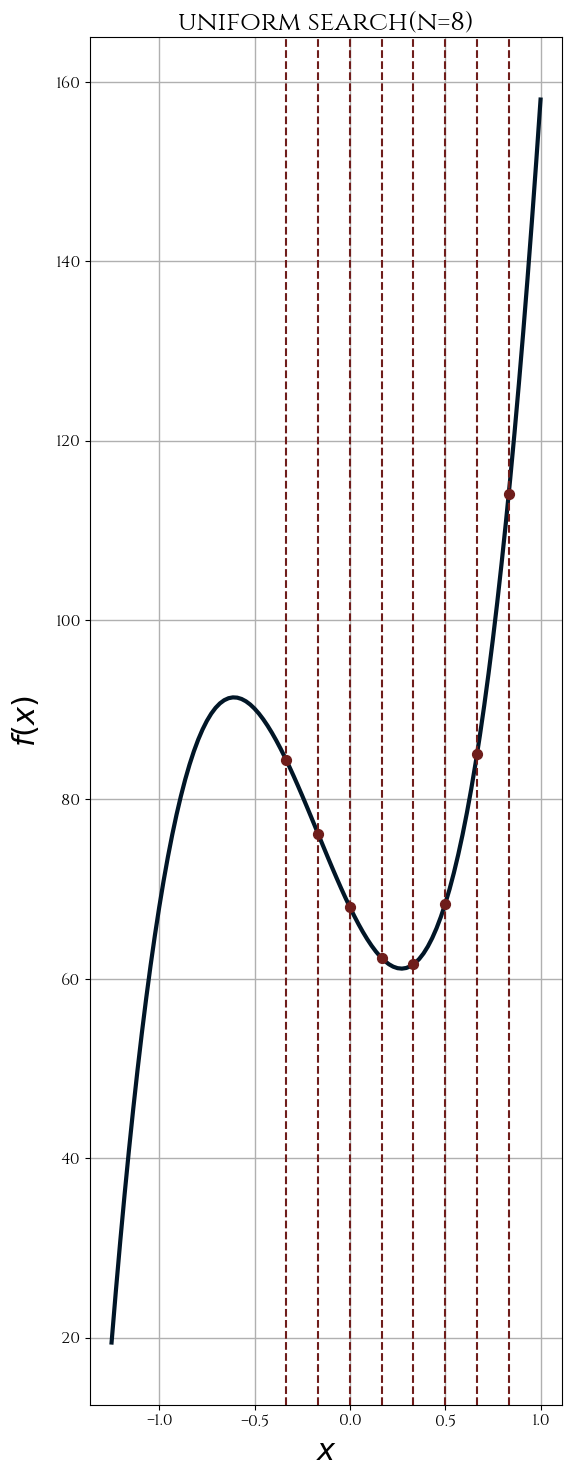

Minimum found at: (x=0.333333; y=61.629630)


In [648]:
min_point, elapsed_time = optimizer.uniform_search(*INTERVAL, showplot=True, 
                                                   n=8, add_to_comparison=False)
print(f'Minimum found at: {min_point:.6f}')

In [649]:
min_point, elapsed_time = optimizer.uniform_search(*INTERVAL) # n = 1000 (default)
print(f'Minimum found at: {min_point:.6f} (execution time: {elapsed_time:.6f}s)')

Minimum found at: (x=0.271728; y=61.152230) (execution time: 0.001004s)


## Broken lines

## Secant

## Newton

<h2> <center> scipy implementation </center> </h2>

In [650]:
# class for scipy implementations
class OptimizationScipy(Optimization):
    # Метод равномерного поиска
    def uniform_search(self, a: float, 
                             b: float,
                             n: int = 1000,
                             add_to_comparison: bool = True):
        # start timer
        start_time = time.perf_counter()
        
        # get result
        res = sp.optimize.brute(self.func, ranges=[(a, b)], 
                                Ns=n, full_output=True)
        minpoint = Point(*res[0], res[1])

        # end timer
        result_time = time.perf_counter() - start_time
        
        # add data to Comparison class
        if add_to_comparison:
            method = Comparison.Method('uniform_search', 'scipy', 
                                        minpoint, result_time)
            cmpr.add_data(method)

        return [minpoint, result_time]
    
    # Метод ломаных
    def broken_lines(self) -> Point:
        raise NotImplementedError("Broken lines method not implemented")

    # Метод секущих
    def secant(self) -> Point:
        raise NotImplementedError("Secant method not implemented")

    # Метод Ньютона
    def newton(self) -> Point:
        raise NotImplementedError("Newton method not implemented")


## Uniform search

In [651]:
# create optimizer and find minimum
optimizer = OptimizationScipy(func=myfunc)

min_point, elapsed_time = optimizer.uniform_search(*INTERVAL) # n = 1000 (default)
print(f'Minimum found at: {min_point:.6f} (execution time: {elapsed_time:.6f}s)')

Minimum found at: (x=0.271009; y=61.152168) (execution time: 0.011910s)


## Broken lines

## Secant

## Newton

<h2> <center> pytorch implementation </center> </h2>

In [652]:
# class for PyTorch implementations
class OptimizationPyTorch(Optimization):
    # Метод равномерного поиска
    def uniform_search(self, a: float, 
                             b: float,
                             n: int = 1000,
                             add_to_comparison: bool = True,
                             device='cpu') -> Point:
        # start timer
        start_time = time.perf_counter()

        # one-dimensional grid
        x_tenzor = torch.linspace(start=a, end=b, steps=n, device=device)
        
        # get corresponding values
        y_tenzor = self.func(x_tenzor)

        # find the index of the minimum value
        min_ind = torch.argmin(y_tenzor)

        # construct a point
        minpoint = Point(x_tenzor[min_ind], 
                         y_tenzor[min_ind])

        # end timer
        result_time = time.perf_counter() - start_time

        # add data to Comparison class
        if add_to_comparison:
            method = Comparison.Method('uniform_search', 'pytorch', 
                                        minpoint, result_time, device)
            cmpr.add_data(method)

        return [minpoint, result_time]
    
    # Метод ломаных
    def broken_lines(self) -> Point:
        raise NotImplementedError("Broken lines method not implemented")

    # Метод секущих
    def secant(self) -> Point:
        raise NotImplementedError("Secant method not implemented")

    # Метод Ньютона
    def newton(self) -> Point:
        raise NotImplementedError("Newton method not implemented")


## Uniform search

In [653]:
# create optimizer and find minimum
optimizer = OptimizationPyTorch(func=myfunc)

# use cpu
min_point, elapsed_time = optimizer.uniform_search(*INTERVAL) # n = 1000 (default)
print(f'(cpu)Minimum found at: {min_point:.6f} (execution time: {elapsed_time:.6f}s)')

""" 
check for n = 1 * 10^8
"""
# use cpu
min_point, elapsed_time = optimizer.uniform_search(*INTERVAL, n=int(1e8), 
                                                   add_to_comparison=False)
print(f'(cpu, n=1e8)Minimum found at: {min_point:.6f} (execution time: {elapsed_time:.6f}s)')

# use gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cpu':
    raise Exception('cuda is not available')

min_point, elapsed_time = optimizer.uniform_search(*INTERVAL, device=device, 
                                                   n=int(1e8), 
                                                   add_to_comparison=False)
print(f'({'gpu' if device=='cuda' else device}, n=1e8)Minimum found at: {min_point:.6f} (execution time: {elapsed_time:.6f}s)')

(cpu)Minimum found at: (x=0.270270; y=61.152233) (execution time: 0.000442s)


(cpu, n=1e8)Minimum found at: (x=0.270859; y=61.152168) (execution time: 1.456683s)
(gpu, n=1e8)Minimum found at: (x=0.270858; y=61.152168) (execution time: 0.039908s)


## Broken lines

## Secant

## Newton

# Comparison

In [654]:
cmpr.get_data()

[Comparison.Method(name='uniform_search', implementation_type='analytical', result=Point(x=0.27172827172827174, y=61.152229844624365), execution_time=0.001003500001388602, details=''),
 Comparison.Method(name='uniform_search', implementation_type='scipy', result=Point(x=np.float64(0.27100929054054057), y=np.float64(61.152168477488594)), execution_time=0.011909799999557436, details=''),
 Comparison.Method(name='uniform_search', implementation_type='pytorch', result=Point(x=tensor(0.2703), y=tensor(61.1522)), execution_time=0.00044169998727738857, details='cpu')]